# Part 1 - Статистические модели прогнозирования. Практика

##№ Импорт бибилиотек

In [258]:
import pandas as pd
from warnings import filterwarnings
filterwarnings("ignore")
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from arch import arch_model
from sklearn.metrics import mean_squared_error

## Задача:

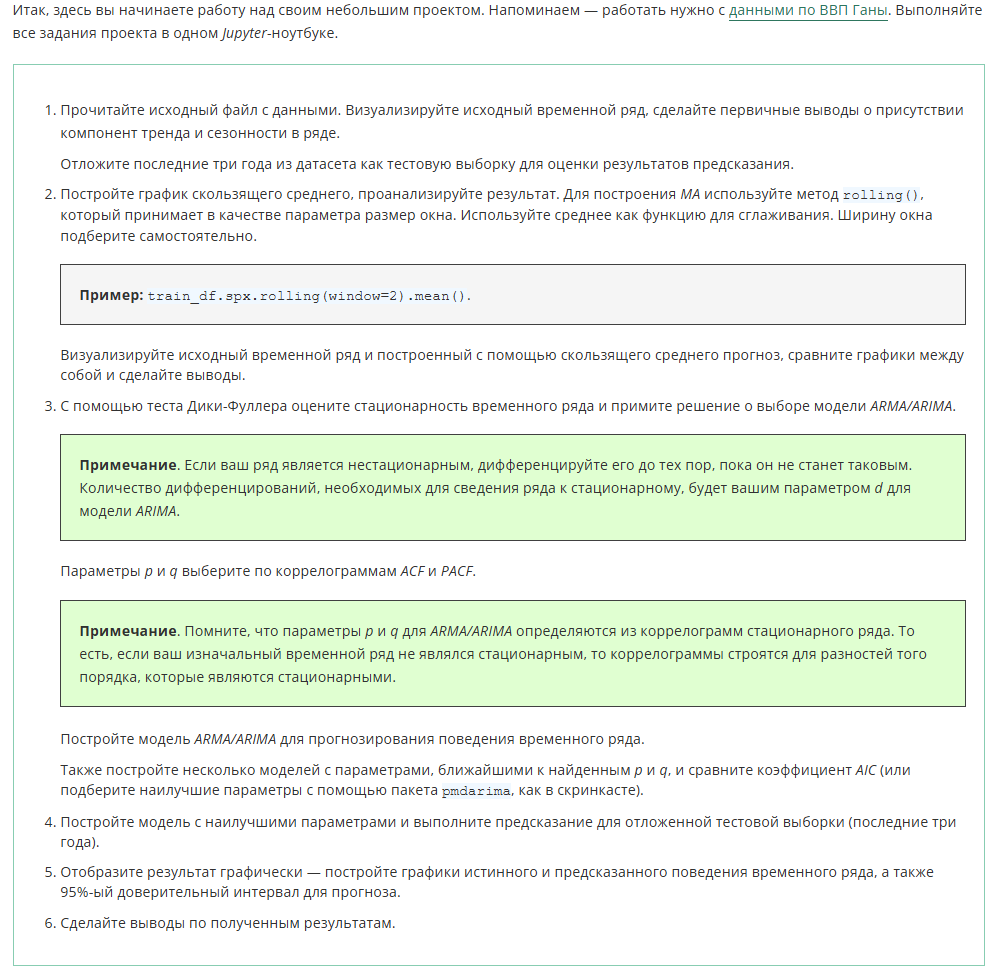

### 1. Прочитайте исходный файл с данными. Визуализируйте исходный временной ряд, сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде.

In [259]:
data = pd.read_csv("data/ghana_gdp.csv", parse_dates=["year"], index_col=["year"])
data.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


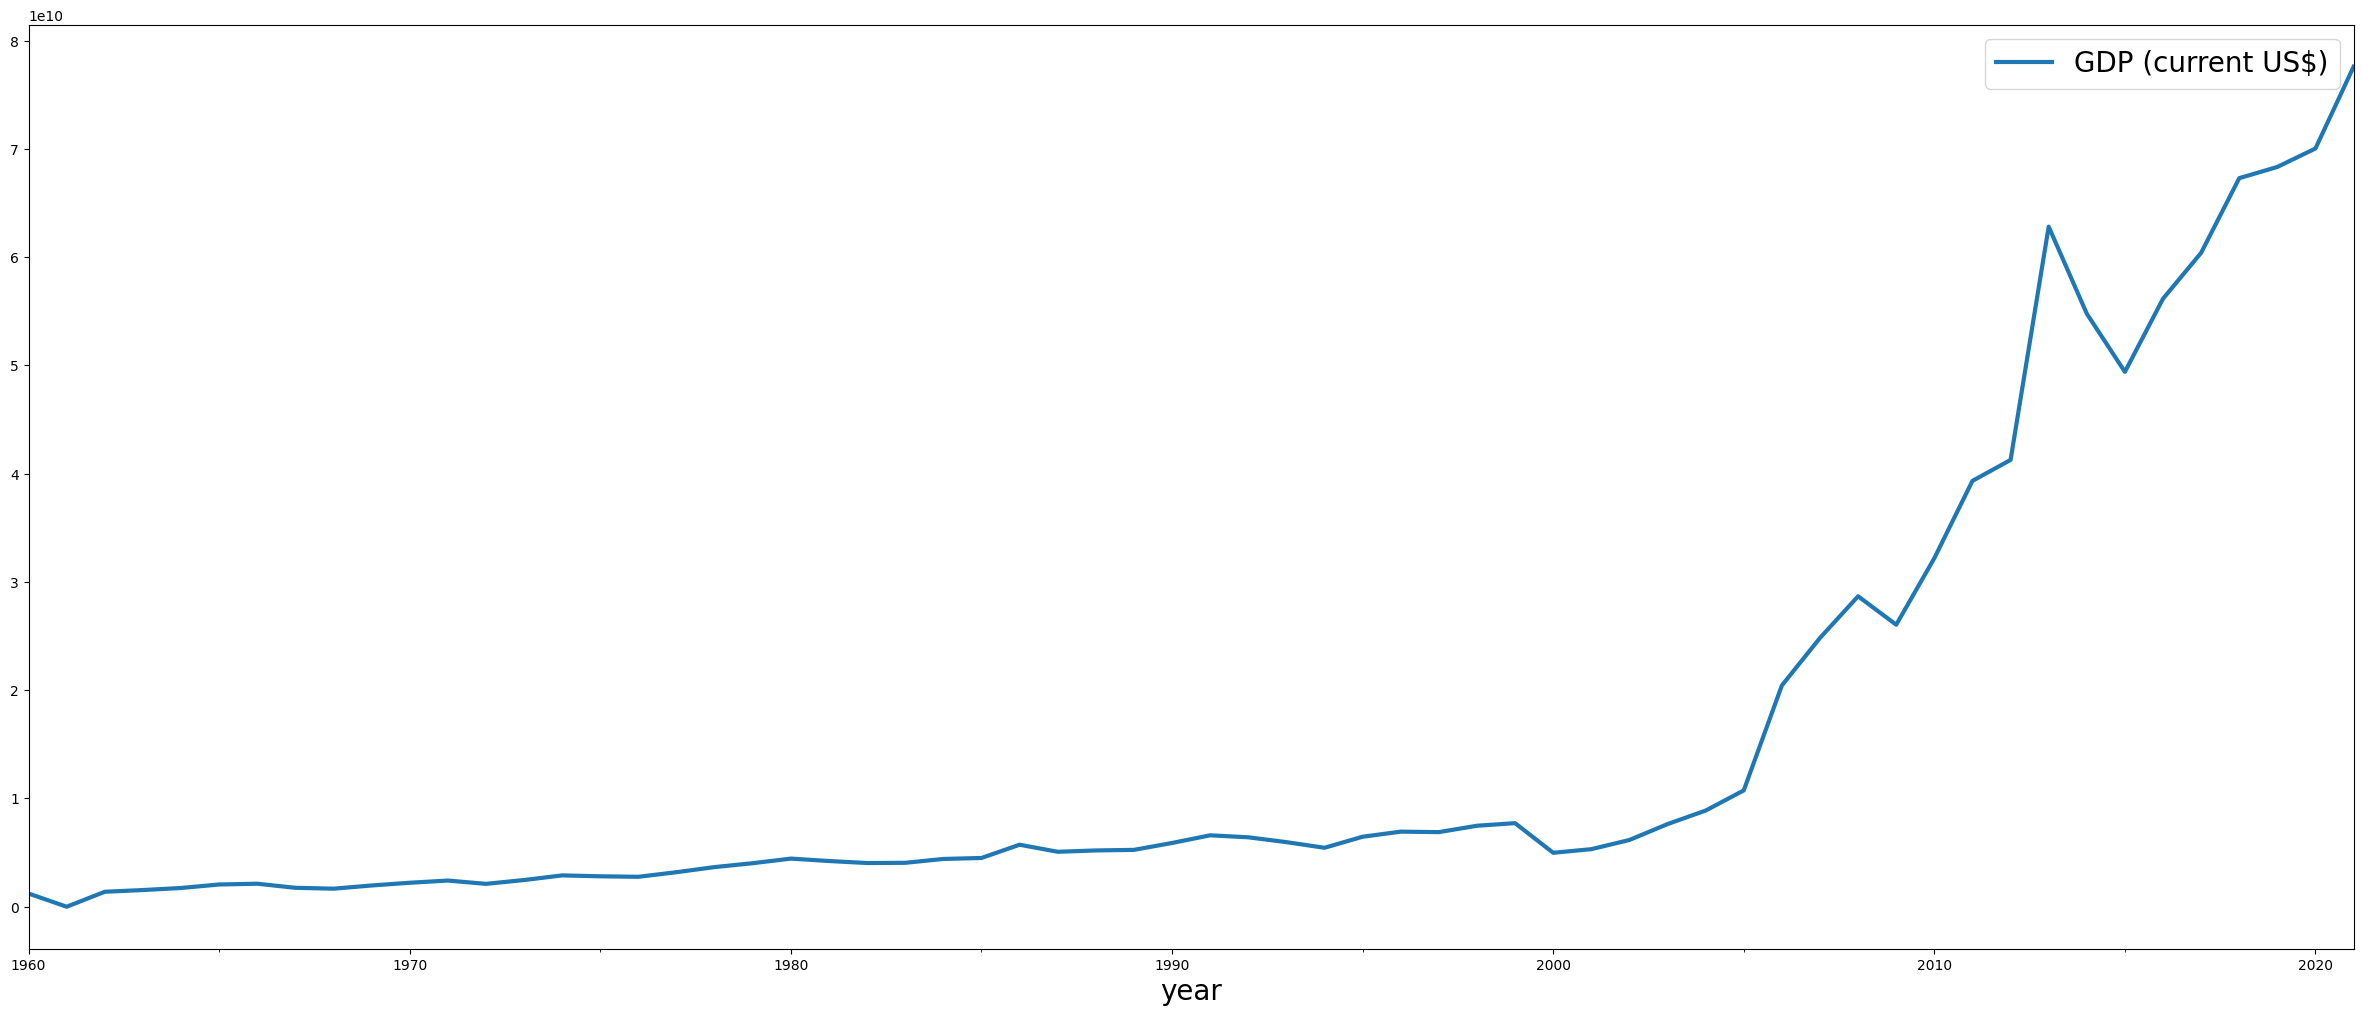

In [260]:
plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

data.plot()
plt.show()

In [261]:
train_df = data.loc[:"2018-12-31"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

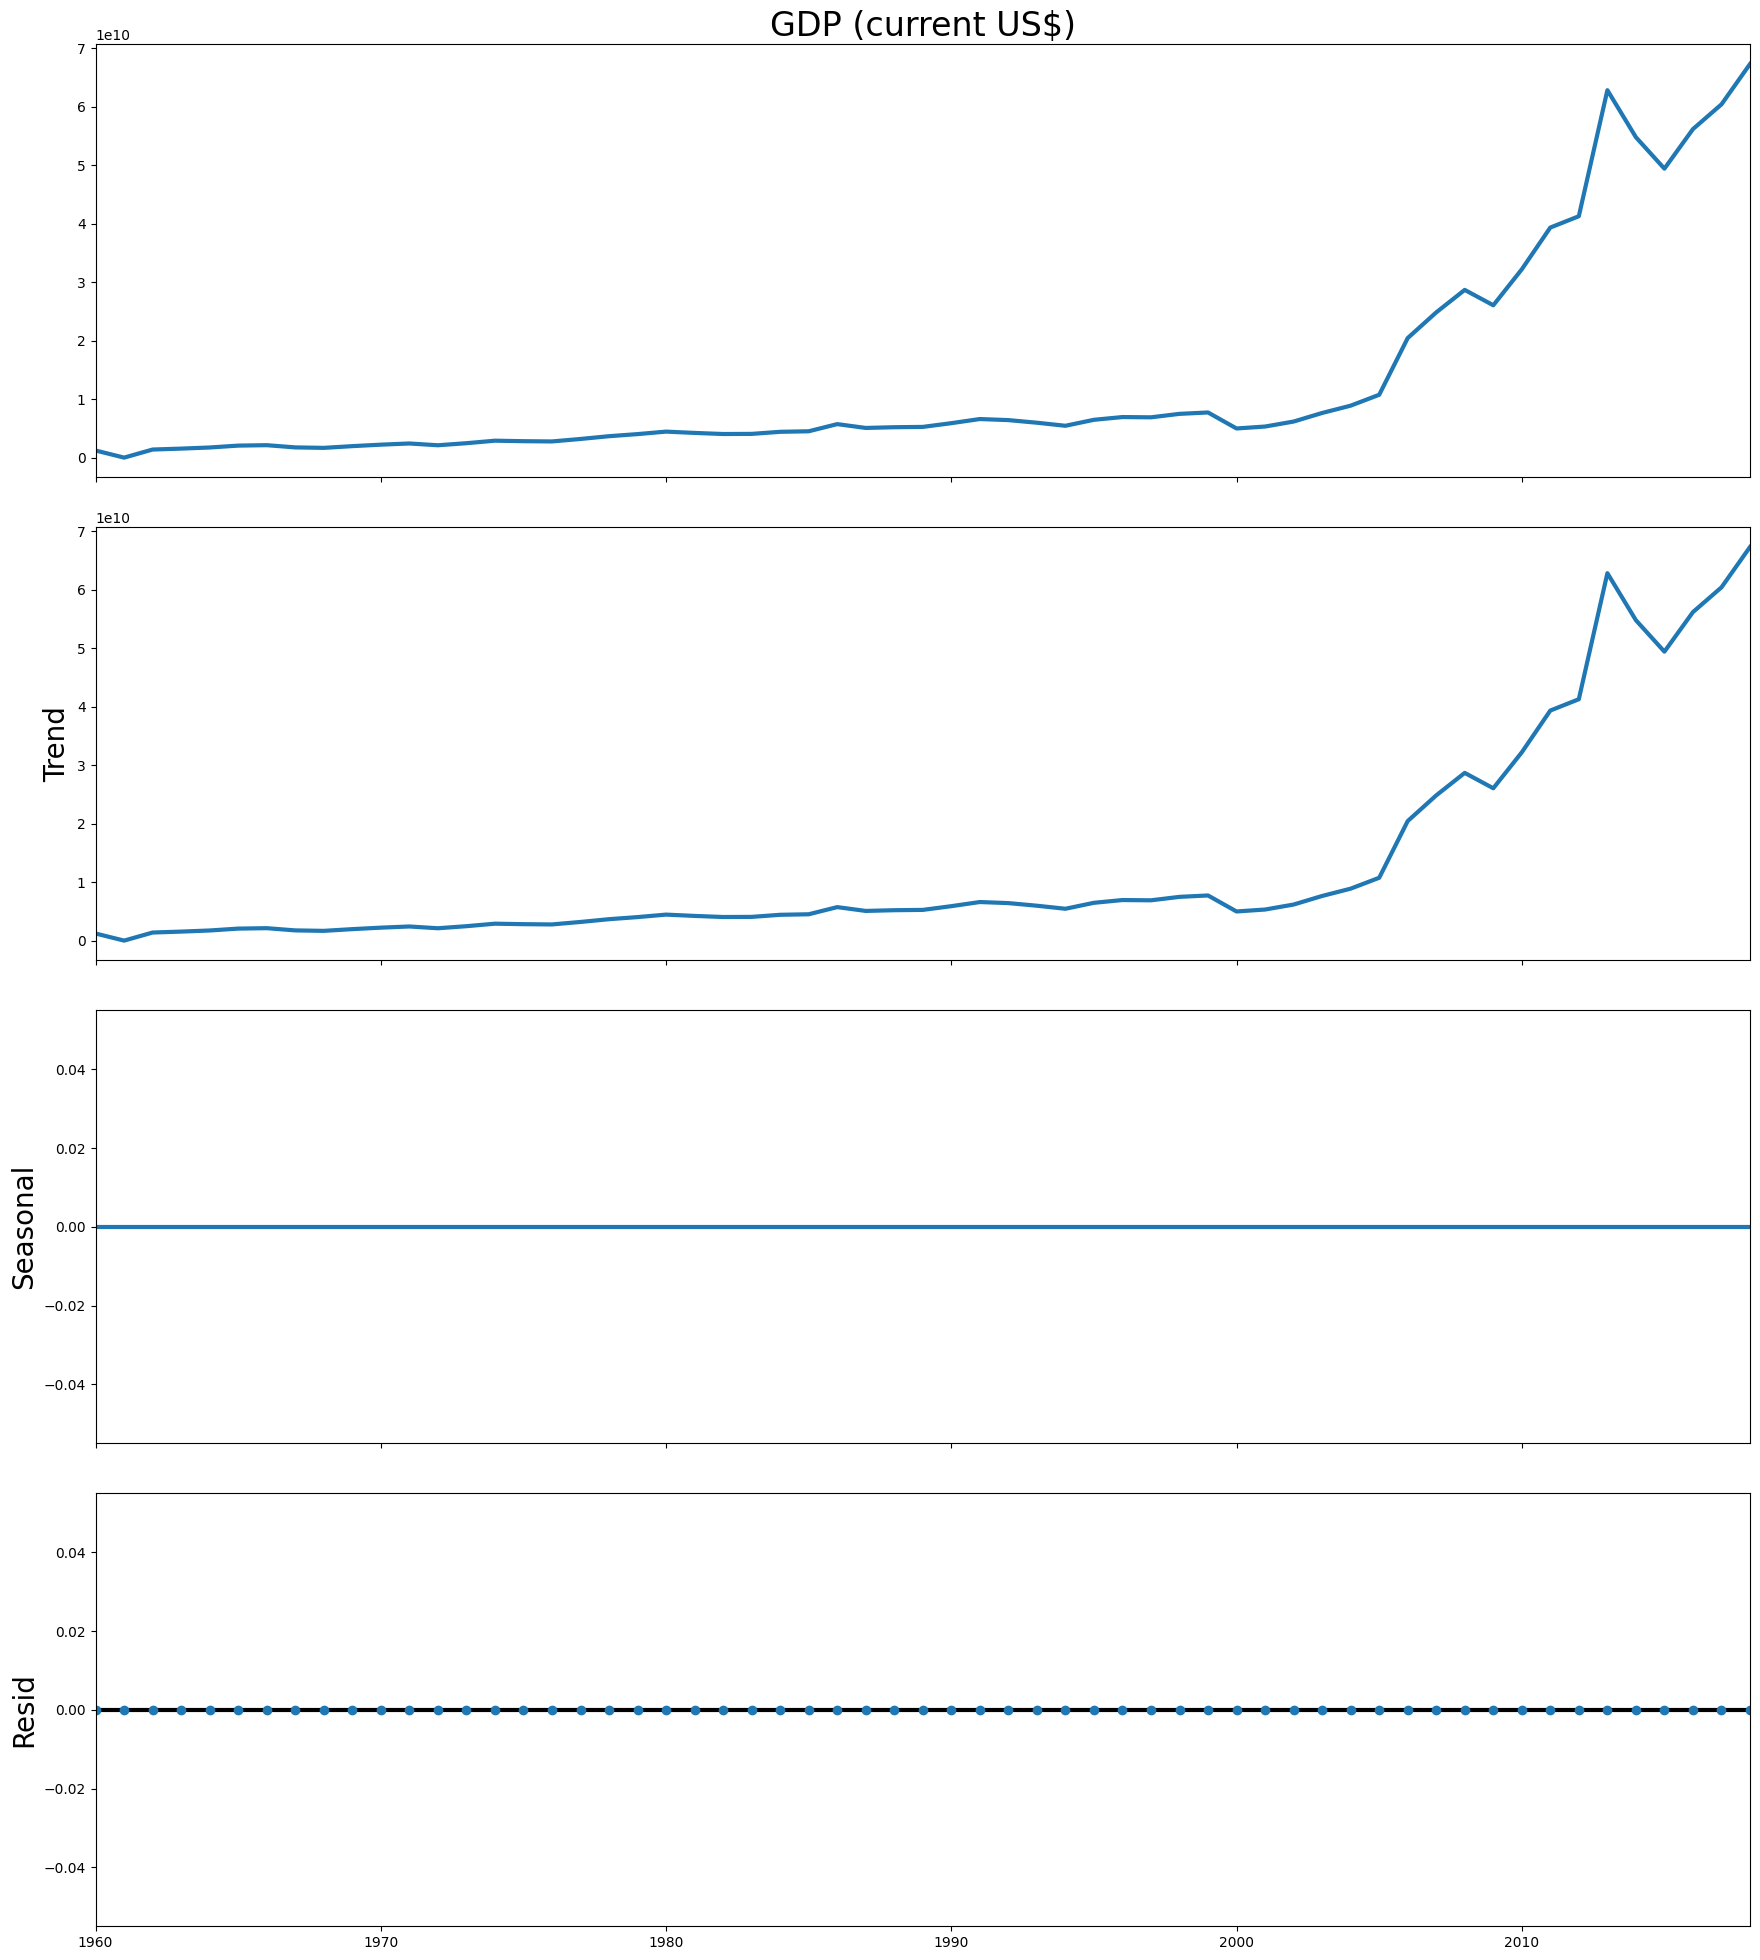

In [262]:
plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(train_df["GDP (current US$)"])
result.plot()
plt.show()

> Вывод:
> - Четко прсолеживает тренд.
> - Сезонность отсутствует, стоит отметить данные ВВП представлены за весь год (даные не разбиты на менее короткие интервалы месяц, квартал и тд)

### 2. Постройте график скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling(), который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.

Пример: train_df.spx.rolling(window=2).mean().

Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.

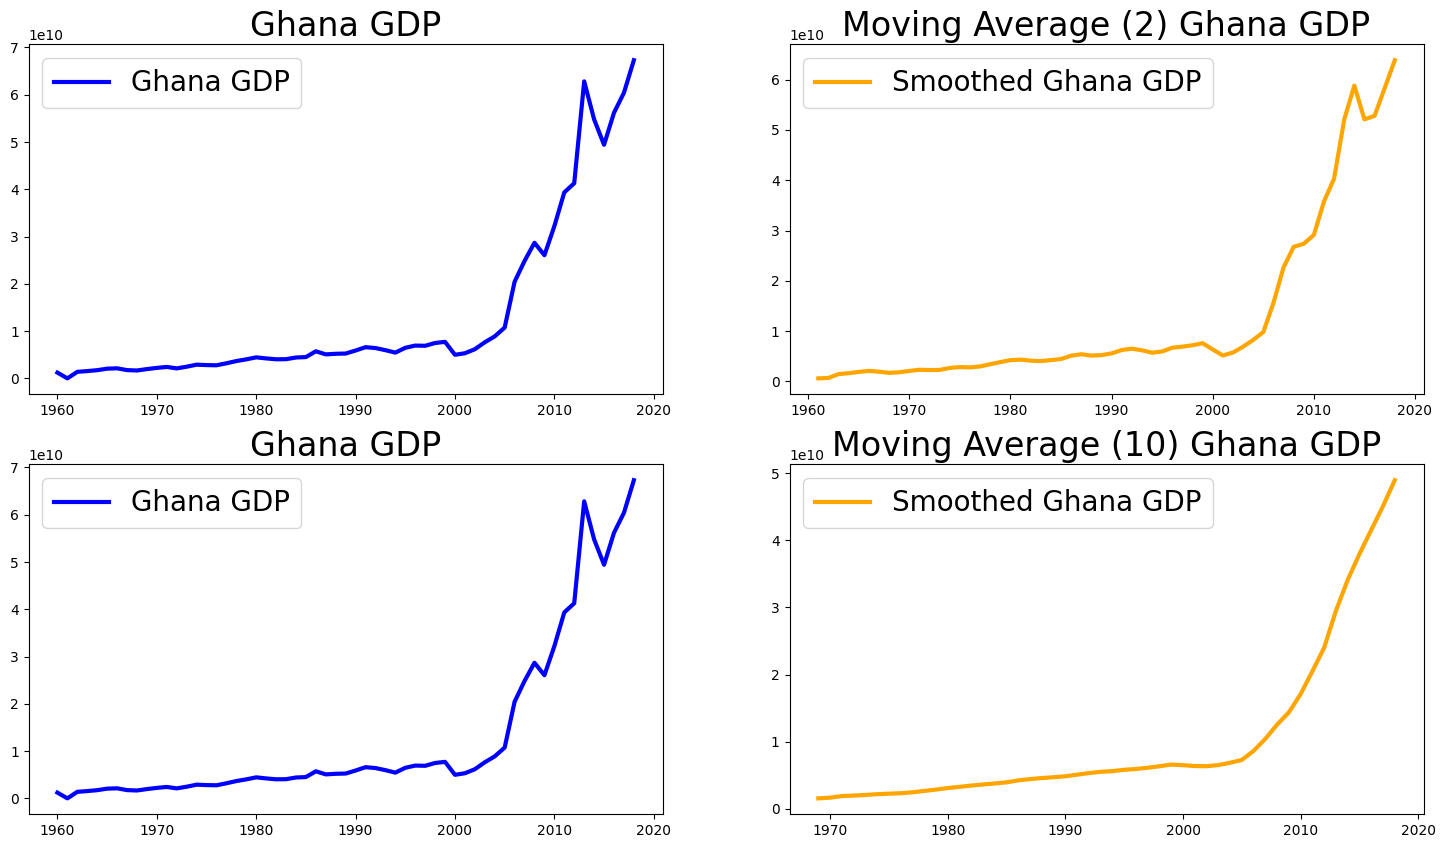

In [263]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

# Окно в 2 лет (Window = 2)
ax[0, 0].plot(train_df["GDP (current US$)"], color="blue", label="Ghana GDP")
ax[0, 0].set_title("Ghana GDP", size=24)
ax[0, 0].legend()

ax[0, 1].plot(
    train_df["GDP (current US$)"].rolling(window=2).mean(),
    color="orange",
    label="Smoothed Ghana GDP",
)

ax[0, 1].set_title("Moving Average (2) Ghana GDP", size=24)
ax[0, 1].legend()


# Окно в 10 лет (Window = 10)
ax[1, 0].plot(train_df["GDP (current US$)"], color="blue", label="Ghana GDP")
ax[1, 0].set_title("Ghana GDP", size=24)
ax[1, 0].legend()

ax[1, 1].plot(
    train_df["GDP (current US$)"].rolling(window=10).mean(),
    color="orange",
    label="Smoothed Ghana GDP",
)

ax[1, 1].set_title("Moving Average (10) Ghana GDP", size=24)
ax[1, 1].legend()

plt.show()

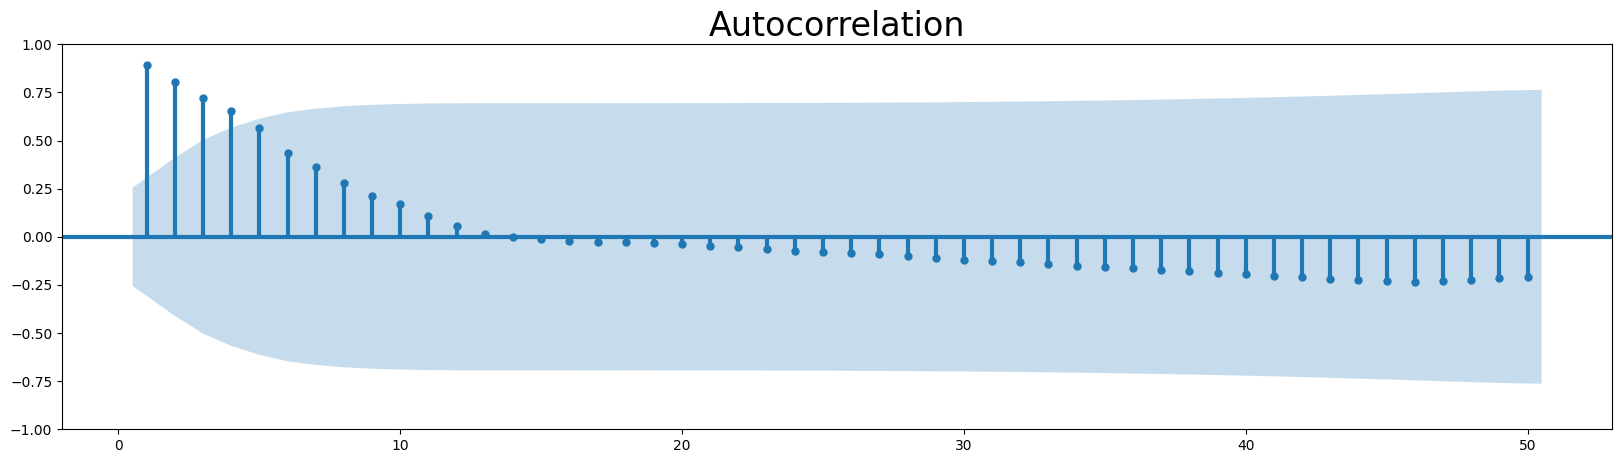

In [264]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df["GDP (current US$)"], lags=50, zero=False)
plt.show()

> Вывод: 
> - Наблюдается хорошая корреляция с Лагом до 4


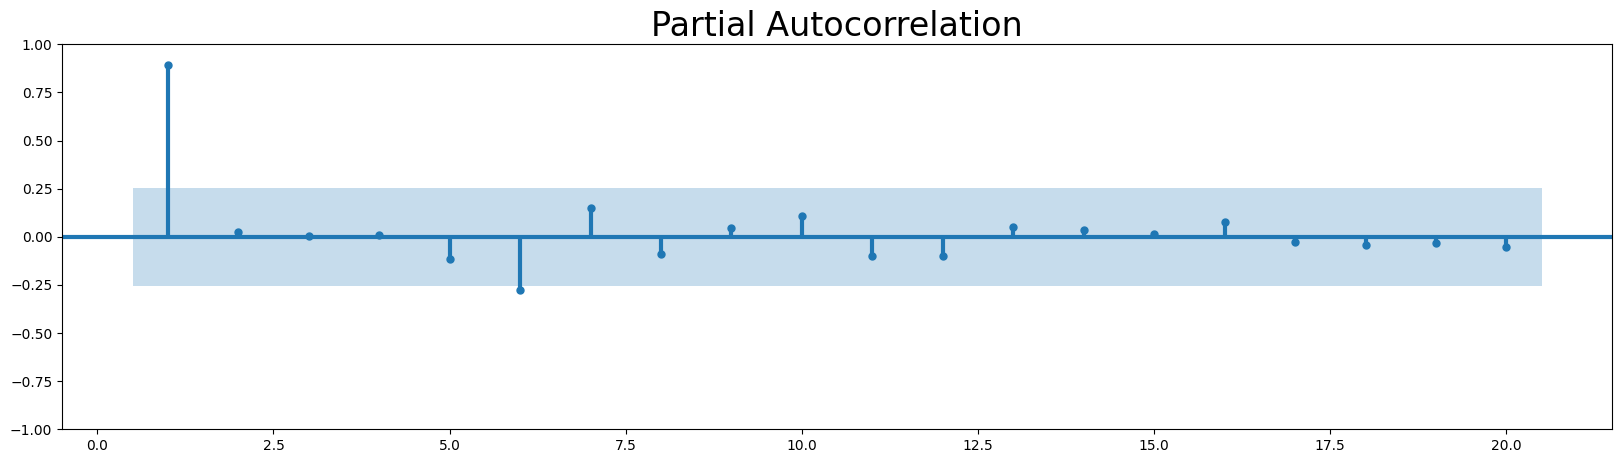

In [265]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df["GDP (current US$)"], lags=20, method="ywm", zero=False)
plt.show()

> Вывод: 
> - GDP (current US$) с лагом >1 не приносят никакой новой информации. В такой ситуации выбираем параметр p =1
> - Судя по графику Лаг "самый отличный от нуля" первый, выбираем p=1.


### 3. С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA.


*Примечание. Если ваш ряд является нестационарным, дифференцируйте его до тех пор, пока он не станет таковым. Количество дифференцирований, необходимых для сведения ряда к стационарному, будет вашим параметром d для модели ARIMA.*

Параметры p и q выберите по коррелограммам ACF и PACF.

*Примечание. Помните, что параметры p и q для ARMA/ARIMA определяются из коррелограмм стационарного ряда. То есть, если ваш изначальный временной ряд не являлся стационарным, то коррелограммы строятся для разностей того порядка, которые являются стационарными.*

Постройте модель ARMA/ARIMA для прогнозирования поведения временного ряда.

Также постройте несколько моделей с параметрами, ближайшими к найденным p и q, и сравните коэффициент AIC (или подберите наилучшие параметры с помощью пакета pmdarima, как в скринкасте).

In [266]:
adfuller(train_df["GDP (current US$)"])

(np.float64(0.6529066974885349),
 np.float64(0.9888496277665572),
 10,
 48,
 {'1%': np.float64(-3.5745892596209488),
  '5%': np.float64(-2.9239543084490744),
  '10%': np.float64(-2.6000391840277777)},
 np.float64(2194.301372914139))

In [267]:
test1 = adfuller(train_df["GDP (current US$)"])
print("adf: ", test1[0])
print("p-value: ", test1[1])
print("Critical values: ", test1[4])
if test1[0] > test1[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  0.6529066974885349
p-value:  0.9888496277665572
Critical values:  {'1%': np.float64(-3.5745892596209488), '5%': np.float64(-2.9239543084490744), '10%': np.float64(-2.6000391840277777)}
ряд нестационарен


> Вывод: Наша статистика больше всех критических значений разных уровней значимости, следовательно мы не можем опровергнуть нулевую теорию. Следовательно наш ряд не является стационарным.

In [268]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=25)
    sgt.plot_pacf(series, ax=axes[1], lags=25, method="ywm")
    plt.show()

## Дифференцирование ряда
$y\_new_t = y_t - y_{t-1}$

where, 
- $y\_new_t$: Дифференцированное значение ряда $t$
- $y_t$: Фактическое значение ряда $t$
- $y_{t-1}$: Фактическое значение ряда $t-1$

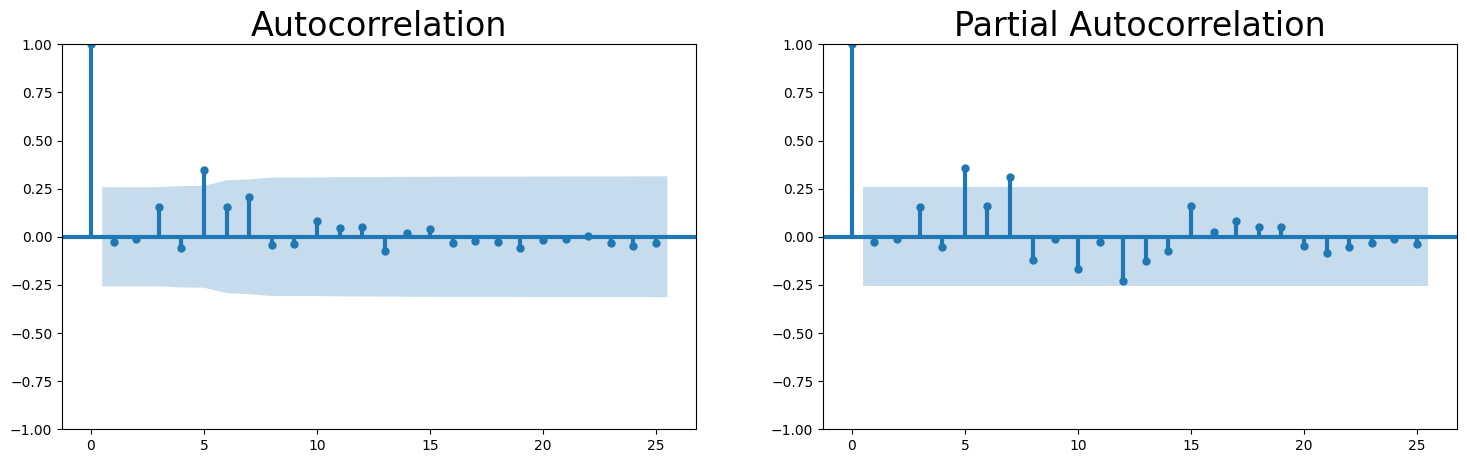

(np.float64(-1.6702483038320777),
 np.float64(0.446502932971389),
 7,
 50,
 {'1%': np.float64(-3.568485864),
  '5%': np.float64(-2.92135992),
  '10%': np.float64(-2.5986616)},
 np.float64(2147.2038799920597))

In [269]:
plot_acf_pacf(train_df["GDP (current US$)"].diff().dropna())
adfuller(train_df["GDP (current US$)"].diff().dropna())

In [270]:
# Тест Дики-Фуллера для дифференцированных данных (первые разности)
diff_test = adfuller(train_df["GDP (current US$)"].diff().dropna())
print("=== Тест Дики-Фуллера для дифференцированных данных ===")
print("adf: ", diff_test[0])
print("p-value: ", diff_test[1])
print("Critical values: ", diff_test[4])
if diff_test[0] > diff_test[4]["5%"]:
    print("Дифференцированный ряд НЕстационарен")
else:
    print("Дифференцированный ряд стационарен")

=== Тест Дики-Фуллера для дифференцированных данных ===
adf:  -1.6702483038320777
p-value:  0.446502932971389
Critical values:  {'1%': np.float64(-3.568485864), '5%': np.float64(-2.92135992), '10%': np.float64(-2.5986616)}
Дифференцированный ряд НЕстационарен


> Вывод:
> - Первые разности являются стационарными
> - Продолжаем дифференцирование

=== Тест Дики-Фуллера для вторых разностей ===
adf:  -2.6408690561284898
p-value:  0.08484116917837664
Critical values:  {'1%': np.float64(-3.5714715250448363), '5%': np.float64(-2.922629480573571), '10%': np.float64(-2.5993358475635153)}
Вторые разности НЕстационарны


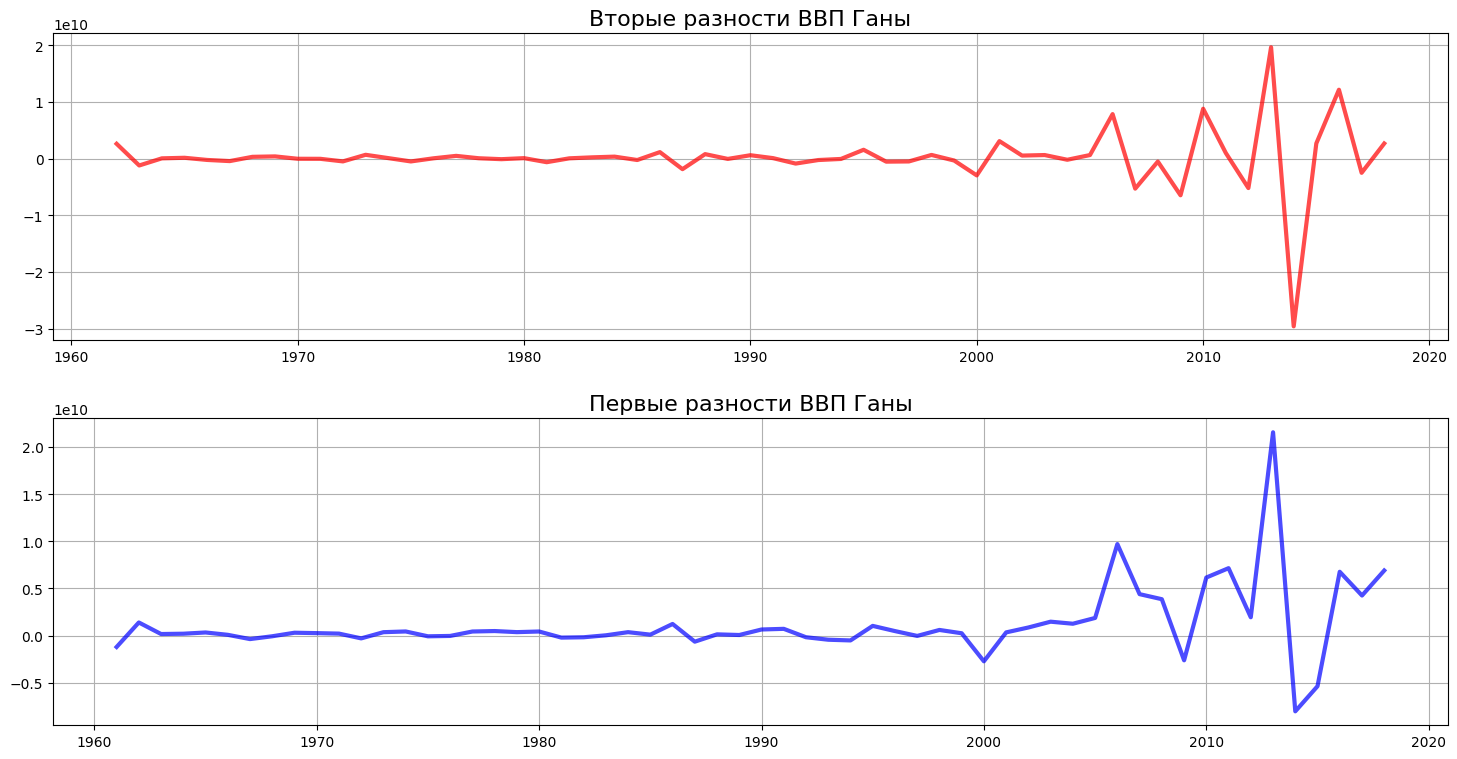

In [271]:
# Проверим вторые разности (d=2)
second_diff = train_df["GDP (current US$)"].diff().diff().dropna()
second_diff_test = adfuller(second_diff)

print("=== Тест Дики-Фуллера для вторых разностей ===")
print("adf: ", second_diff_test[0])
print("p-value: ", second_diff_test[1])
print("Critical values: ", second_diff_test[4])

if second_diff_test[0] > second_diff_test[4]["5%"]:
    print("Вторые разности НЕстационарны")
else:
    print("Вторые разности стационарны")
    
# Визуализируем вторые разности
plt.rcParams["figure.figsize"] = 15, 8
fig, axes = plt.subplots(2, 1)

# График вторых разностей
axes[0].plot(second_diff, color='red', alpha=0.7)
axes[0].set_title('Вторые разности ВВП Ганы' , size=16)
axes[0].grid(True)

# График первых разностей для сравнения  
axes[1].plot(train_df["GDP (current US$)"].diff().dropna(), color='blue', alpha=0.7)
axes[1].set_title('Первые разности ВВП Ганы', size=16)
axes[1].grid(True)

plt.tight_layout()
plt.show()

> Вывод:
> - Вторые разности d=2 показывают значительное улучшение
> - Результат: На 5% уровне значимости НЕстационарны, но на 10% уровне стационарны
> - Визуально вторые разности ведут себя более стационарно до 2000-х годов, но показывают повышенную волатильность в последние годы
> - Будем использовать d=2 (вторые разности). Сравним их с d=3 и сравним AIC 

## ARIMA, SARIMA

Начнем построение модели **ARIMA** со следующими параметрами:

- p = 1 
- d = 2 
- q = 1 


In [272]:
arima_model = ARIMA(train_df["GDP (current US$)"].dropna(), order=(1, 2, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1339.208
Date:                Wed, 11 Feb 2026   AIC                           2684.416
Time:                        21:44:46   BIC                           2690.545
Sample:                    01-01-1960   HQIC                          2686.798
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1775      0.082     -2.159      0.031      -0.339      -0.016
ma.L1         -0.8688      0.046    -19.069      0.000      -0.958      -0.780
sigma2       1.96e+19   2.13e-22    9.2e+40      0.000    1.96e+19    1.96e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               276.42
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):             325.65   Skew:                             1.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.49e+56. Standard errors may be unstable.
"""

Сравним с моделью **ARIMA** со следующими параметрами:

- p = 1 
- d = 3 (дифференцирование и сравним AIC) 
- q = 1 

In [273]:
arima_model_2 = ARIMA(train_df["GDP (current US$)"].dropna(), order=(1, 3, 1))
arima_model_fit_2 = arima_model.fit()
arima_model_fit_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1339.208
Date:                Wed, 11 Feb 2026   AIC                           2684.416
Time:                        21:44:46   BIC                           2690.545
Sample:                    01-01-1960   HQIC                          2686.798
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1775      0.082     -2.159      0.031      -0.339      -0.016
ma.L1         -0.8688      0.046    -19.069      0.000      -0.958      -0.780
sigma2       1.96e+19   2.13e-22    9.2e+40      0.000    1.96e+19    1.96e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               276.42
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):             325.65   Skew:                             1.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.49e+56. Standard errors may be unstable.
"""

> Вывод:
> - AIC для d=2 составляет 2684
> - AIC для d=3 составляет 2670 (немного лучше)
> - Разность не значительна, оставим d=2 

In [274]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["GDP (current US$)"] = data["GDP (current US$)"]

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

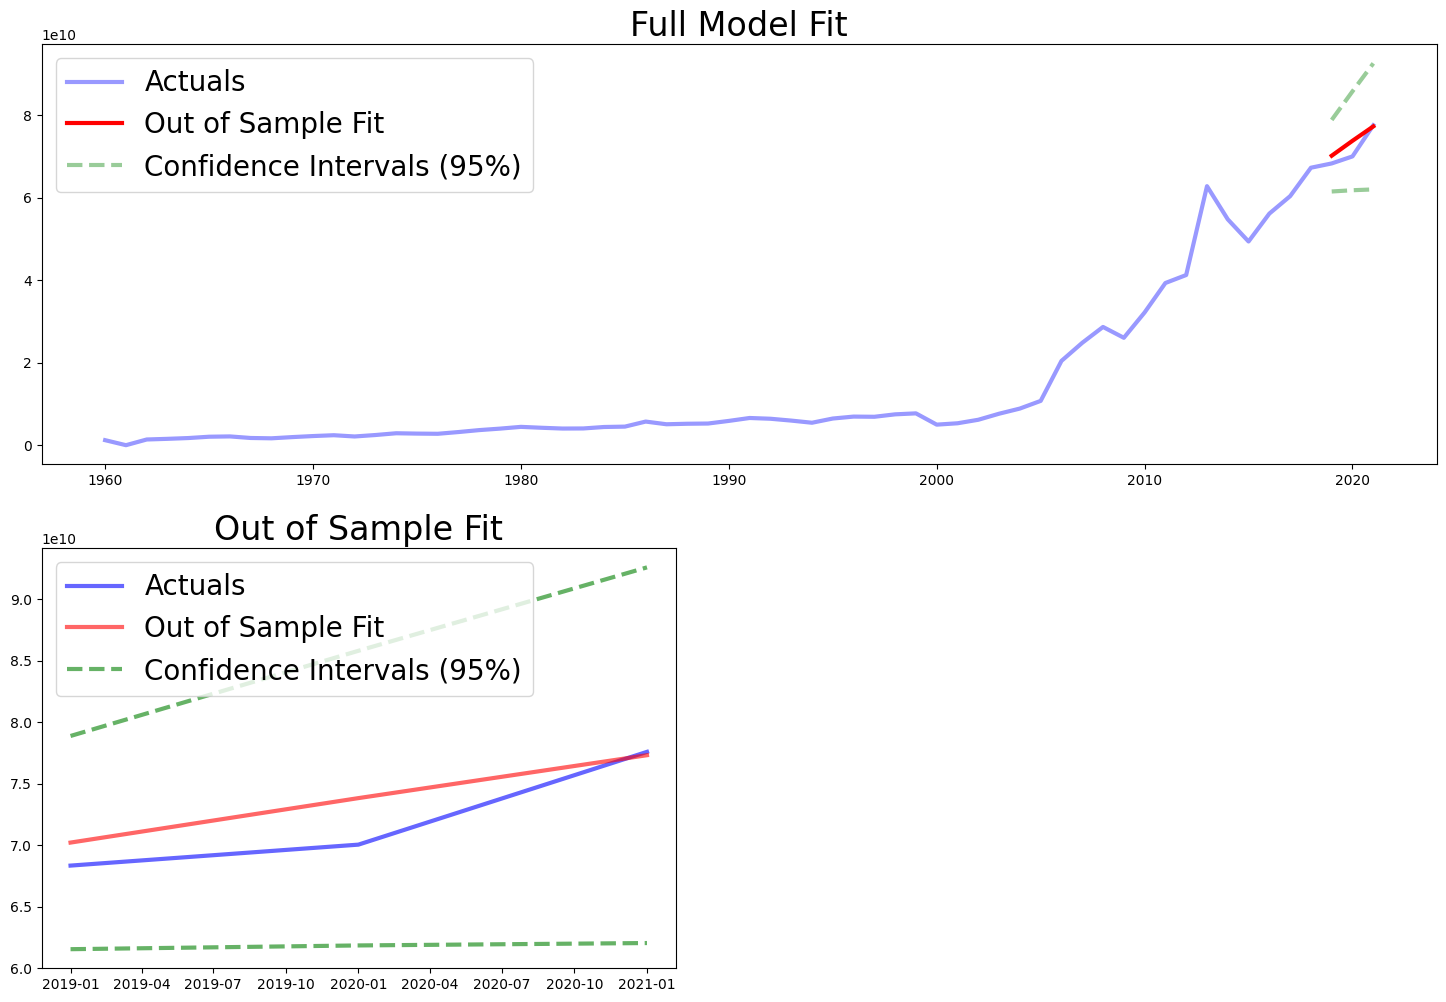

In [275]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

> Вывод:
> - Предсказания уловили тренд и очень близки к реальным значения ВВП за последние 3 года
> - Далее проверю по сетке и подберу лучшие значения по библиотеке "pmdarima"

### 4. Постройте модель с наилучшими параметрами и выполните предсказание для отложенной тестовой выборки (последние три года).
### 5. Отобразите результат графически — постройте графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.
### 6. Сделайте выводы по полученным результатам.

Пробежимся по сетке и найдем лучшие значения p, d, q

In [276]:
# Автоматический подбор оптимальной ARIMA модели 
# Используем результаты наших тестов: d=2 для стационарности
smodel = pm.auto_arima(
    train_df["GDP (current US$)"],  # Указываем конкретную колонку
    start_p=0,
    d=2,  # Используем d=2 как выявили в анализе стационарности
    start_q=0,
    max_p=5,  # Расширяем диапазон поиска
    max_q=5,
    seasonal=False,  # Убираем сезоность, так как её нет в годовых данных
    test="adf", 
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
    trace=True,
)

print("=== Результаты автоматического подбора ARIMA ===")
smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.886, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.594, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.662, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.959, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.339, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.054, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.896, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.06 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.926, Time=0.03 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.782, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.416, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2693.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.382
Date:                Wed, 11 Feb 2026   AIC                           2680.765
Time:                        21:44:49   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.62e+54. Standard errors may be unstable.
"""

> Используем "Best model:  ARIMA(1,2,3)"

In [277]:
arima_model_best = ARIMA(train_df["GDP (current US$)"].dropna(), order=(1, 2, 3))
arima_model_best_fit = arima_model_best.fit()
arima_model_best_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.382
Date:                Wed, 11 Feb 2026   AIC                           2680.765
Time:                        21:44:49   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.62e+54. Standard errors may be unstable.
"""

In [278]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = arima_model_best_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["GDP (current US$)"] = data["GDP (current US$)"]

forecast = arima_model_best_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

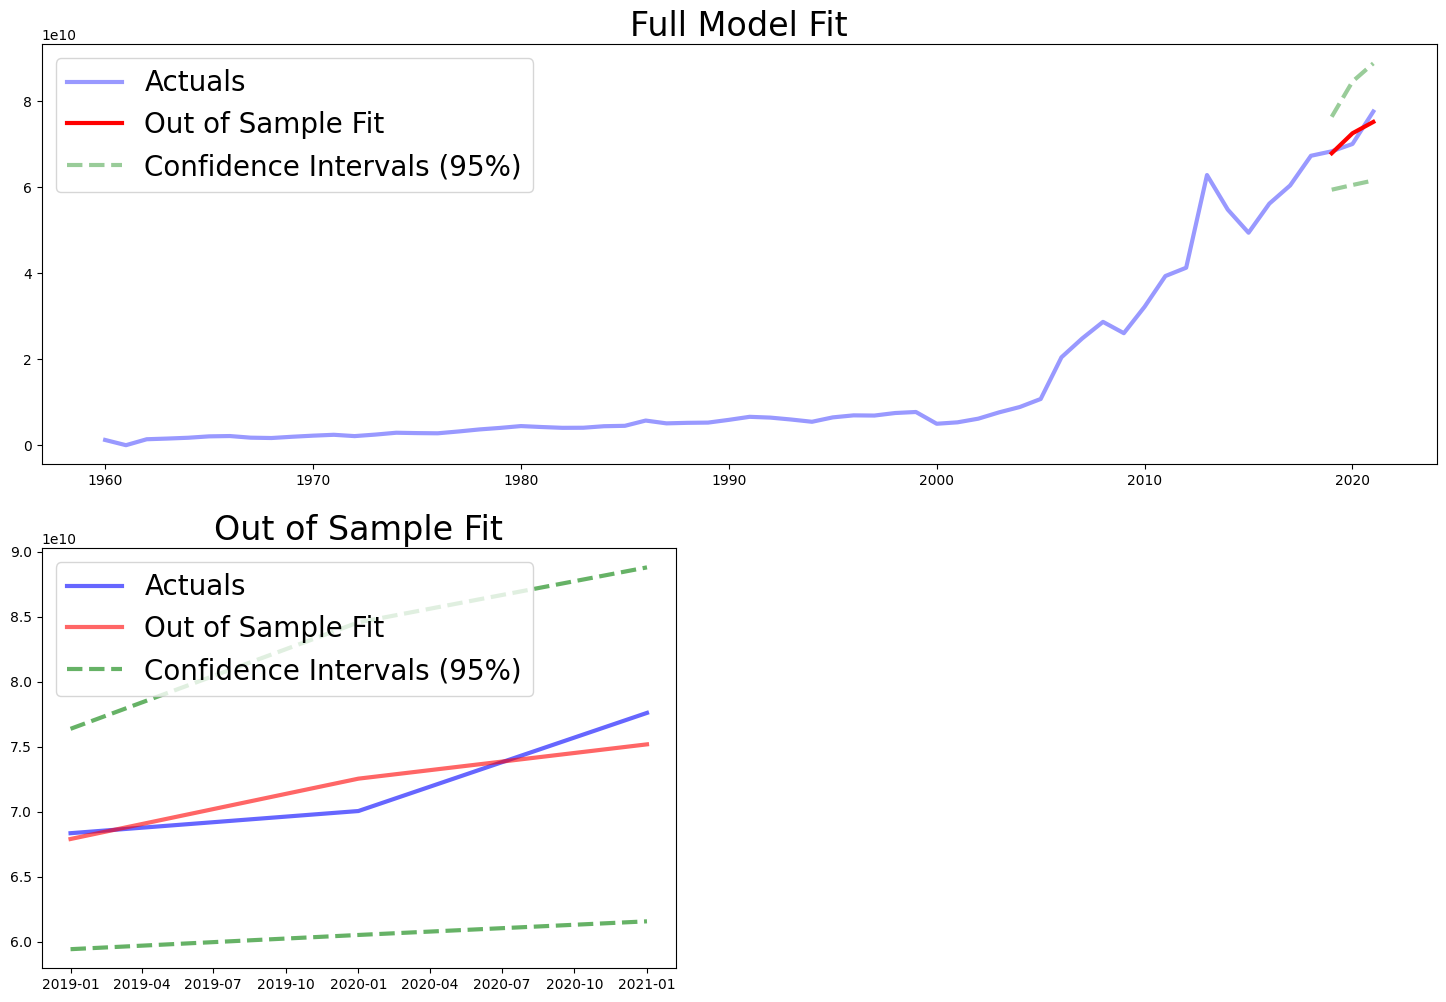

In [279]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

> Вывод:
> - Предсказания ВВП за последние 3 года улучшились по сравнению с первой моделью
> - Предсказания уловили тренд и очень близки к реальным значения ВВП

# Part 2 - Интерполяция и сэмплирование. Практика

## Задача:

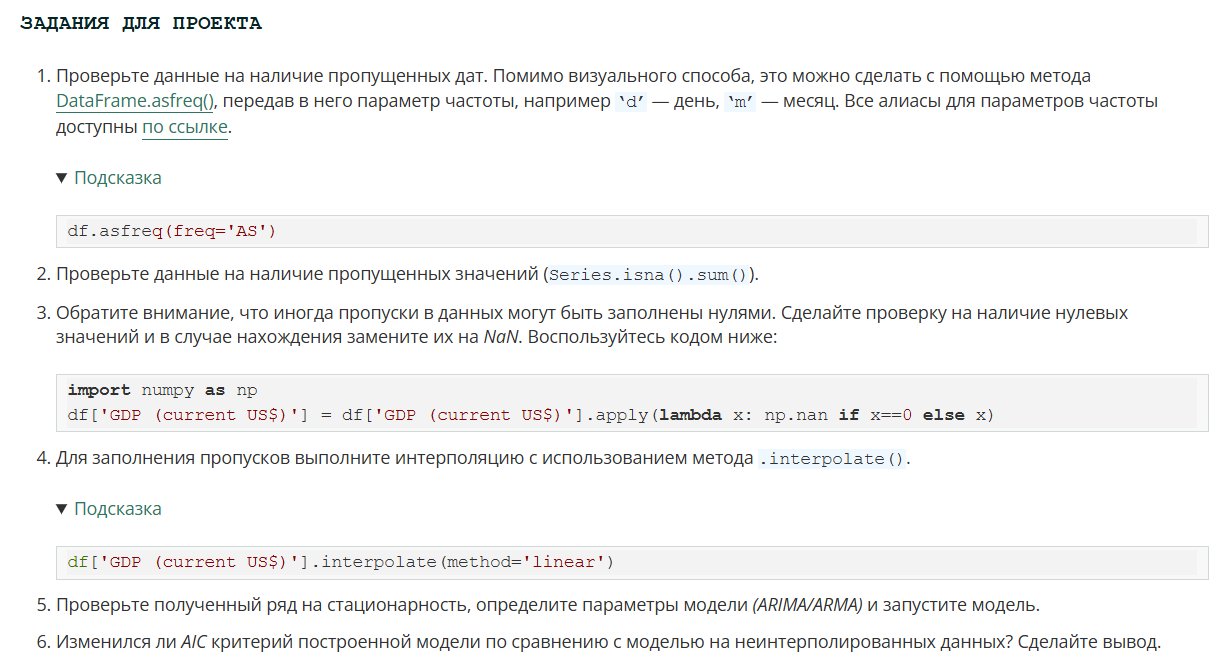

### 1. Проверьте данные на наличие пропущенных дат. Помимо визуального способа, это можно сделать с помощью метода DataFrame.asfreq(), передав в него параметр частоты, например ‘d’ — день, ‘m’ — месяц. Все алиасы для параметров частоты доступны по ссылке.

In [280]:
# 'AS' - Annual Start (начало года)
data.asfreq(freq='AS')

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


> Вывод: 
> - Данные охватывают непрерывный период с 1960 по 2021 год (62 года) без пропусков дат.

### 2. Проверьте данные на наличие пропущенных значений (Series.isna().sum()).

In [281]:
# Проверка пропущенных значений
print("Пропущенные значения в данных:")
print(data.isna().sum())

Пропущенные значения в данных:
GDP (current US$)    0
dtype: int64


> Вывод: 
> - Пропуски в данных отсутствуют

### 3. Обратите внимание, что иногда пропуски в данных могут быть заполнены нулями. Сделайте проверку на наличие нулевых значений и в случае нахождения замените их на NaN. Воспользуйтесь кодом ниже:

In [282]:
# Проверка на нулевые значения
print("Количество нулевых значений:", (data['GDP (current US$)'] == 0).sum())

# Показать строки с нулевыми значениями
zero_rows = data[data['GDP (current US$)'] == 0]
print(f"\nСтроки с нулевыми значениями ({len(zero_rows)} шт.):")
print(zero_rows)

Количество нулевых значений: 1

Строки с нулевыми значениями (1 шт.):
            GDP (current US$)
year                         
1961-01-01                0.0


In [283]:
# Заменяю нулевые значения на NaN и создаю копию данных
interpolated_data = data.copy()
interpolated_data['GDP (current US$)'] = interpolated_data['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

> Вывод: 
> - Присутствует нулевое значение за 1961 год (пропуск заполнен 0)
> - Заменили ноль на Nan

### 4. Для заполнения пропусков выполните интерполяцию с использованием метода .interpolate().

In [284]:
# Выполняем интерполяцию
interpolated_data['GDP (current US$)'] = interpolated_data['GDP (current US$)'].interpolate(method='linear')
interpolated_data.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,1.299720e+09
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


> Вывод: 
> - Значение Nan за 1961 год линейно проинтерполировали 

### 5. Проверьте полученный ряд на стационарность, определите параметры модели (ARIMA/ARMA) и запустите модель.

In [285]:
# делим на train и test
train_df = interpolated_data.loc[:"2018-12-31"]
test_df = interpolated_data.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

In [286]:
# Проводим тест Дики-Фуллера на интерполированных данных
test1 = adfuller(train_df["GDP (current US$)"])
print("adf: ", test1[0])
print("p-value: ", test1[1])
print("Critical values: ", test1[4])
if test1[0] > test1[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  0.8030073326980129
p-value:  0.9916845572455877
Critical values:  {'1%': np.float64(-3.5745892596209488), '5%': np.float64(-2.9239543084490744), '10%': np.float64(-2.6000391840277777)}
ряд нестационарен


> Вывод:
> - Наша статистика больше всех критических значений разных уровней значимости, следовательно мы не можем опровергнуть нулевую теорию. Следовательно наш ряд не является стационарным.
> - Применим сразу вторую дифференциацию 

=== Тест Дики-Фуллера для вторых разностей ===
adf:  -2.634634746007842
p-value:  0.0860481372219768
Critical values:  {'1%': np.float64(-3.5714715250448363), '5%': np.float64(-2.922629480573571), '10%': np.float64(-2.5993358475635153)}
Вторые разности НЕстационарны


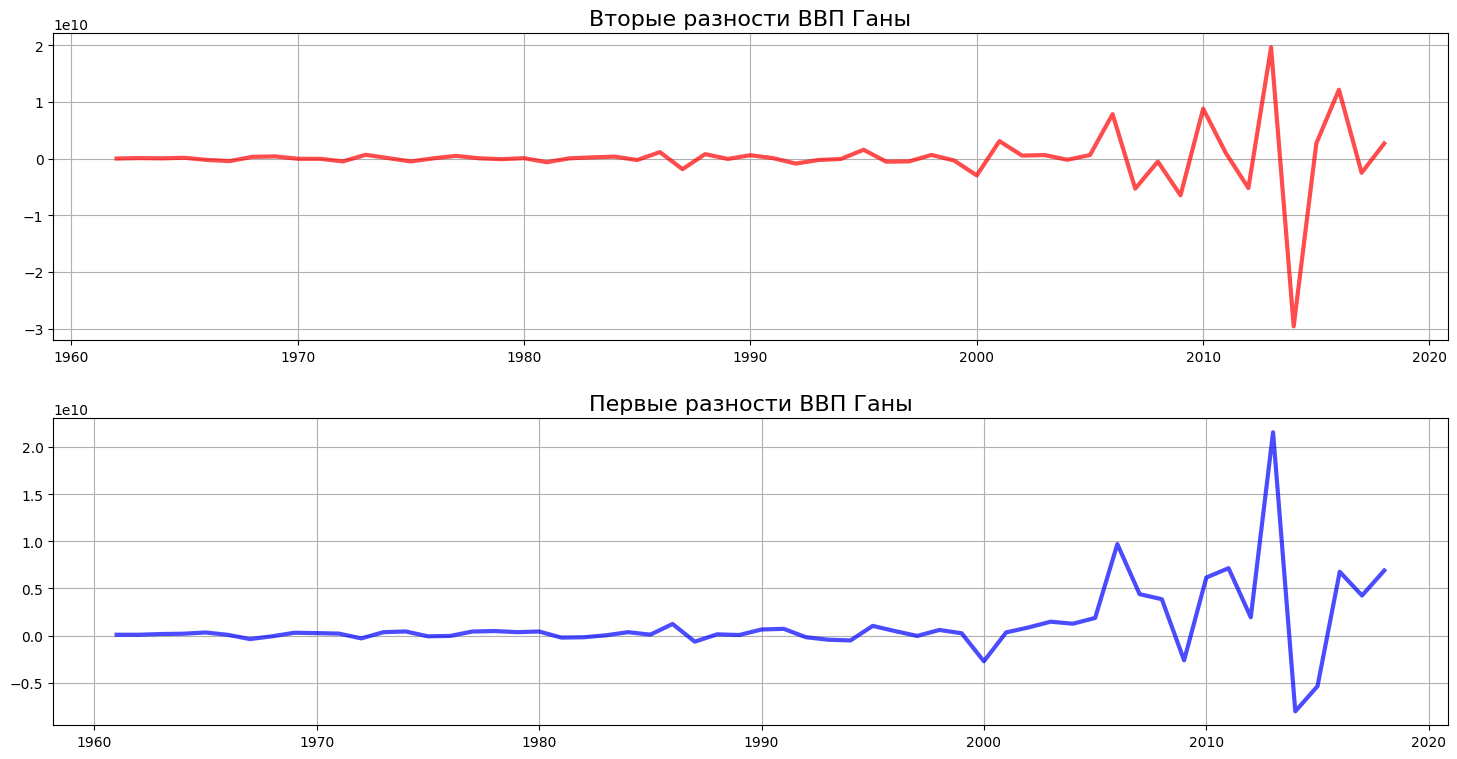

In [287]:
# Проверим вторые разности (d=2)
second_diff = train_df["GDP (current US$)"].diff().diff().dropna()
second_diff_test = adfuller(second_diff)

print("=== Тест Дики-Фуллера для вторых разностей ===")
print("adf: ", second_diff_test[0])
print("p-value: ", second_diff_test[1])
print("Critical values: ", second_diff_test[4])

if second_diff_test[0] > second_diff_test[4]["5%"]:
    print("Вторые разности НЕстационарны")
else:
    print("Вторые разности стационарны")
    
# Визуализируем вторые разности
plt.rcParams["figure.figsize"] = 15, 8
fig, axes = plt.subplots(2, 1)

# График вторых разностей
axes[0].plot(second_diff, color='red', alpha=0.7)
axes[0].set_title('Вторые разности ВВП Ганы' , size=16)
axes[0].grid(True)

# График первых разностей для сравнения  
axes[1].plot(train_df["GDP (current US$)"].diff().dropna(), color='blue', alpha=0.7)
axes[1].set_title('Первые разности ВВП Ганы', size=16)
axes[1].grid(True)

plt.tight_layout()
plt.show()

> Вывод:
> - Вторые разности d=2 практически не изменились по сравнению с "не интерполированными данными"
> - оставляем d=2 как и ранее

Пробежимся по сетке и найдем лучшие значения p, d, q

In [288]:
# Автоматический подбор оптимальной ARIMA модели 
# Используем результаты наших тестов: d=2 для стационарности
smodel = pm.auto_arima(
    train_df["GDP (current US$)"],  # Указываем конкретную колонку
    start_p=0,
    d=2,  # Используем d=2 как выявили в анализе стационарности
    start_q=0,
    max_p=5,  # Расширяем диапазон поиска
    max_q=5,
    seasonal=False,  # Убираем сезоность, так как её нет в годовых данных
    test="adf", 
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
    trace=True,
)

print("=== Результаты автоматического подбора ARIMA ===")
smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.621, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.528, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.683, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.479, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.221, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.822, Time=0.01 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.929, Time=0.05 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.861, Time=0.02 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.709, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.377, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2692.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.257
Date:                Wed, 11 Feb 2026   AIC                           2680.513
Time:                        21:44:52   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.68e+54. Standard errors may be unstable.
"""

In [289]:
arima_model_best = ARIMA(train_df["GDP (current US$)"].dropna(), order=(1, 2, 3))
arima_model_best_fit = arima_model_best.fit()
arima_model_best_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.257
Date:                Wed, 11 Feb 2026   AIC                           2680.513
Time:                        21:44:52   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.68e+54. Standard errors may be unstable.
"""

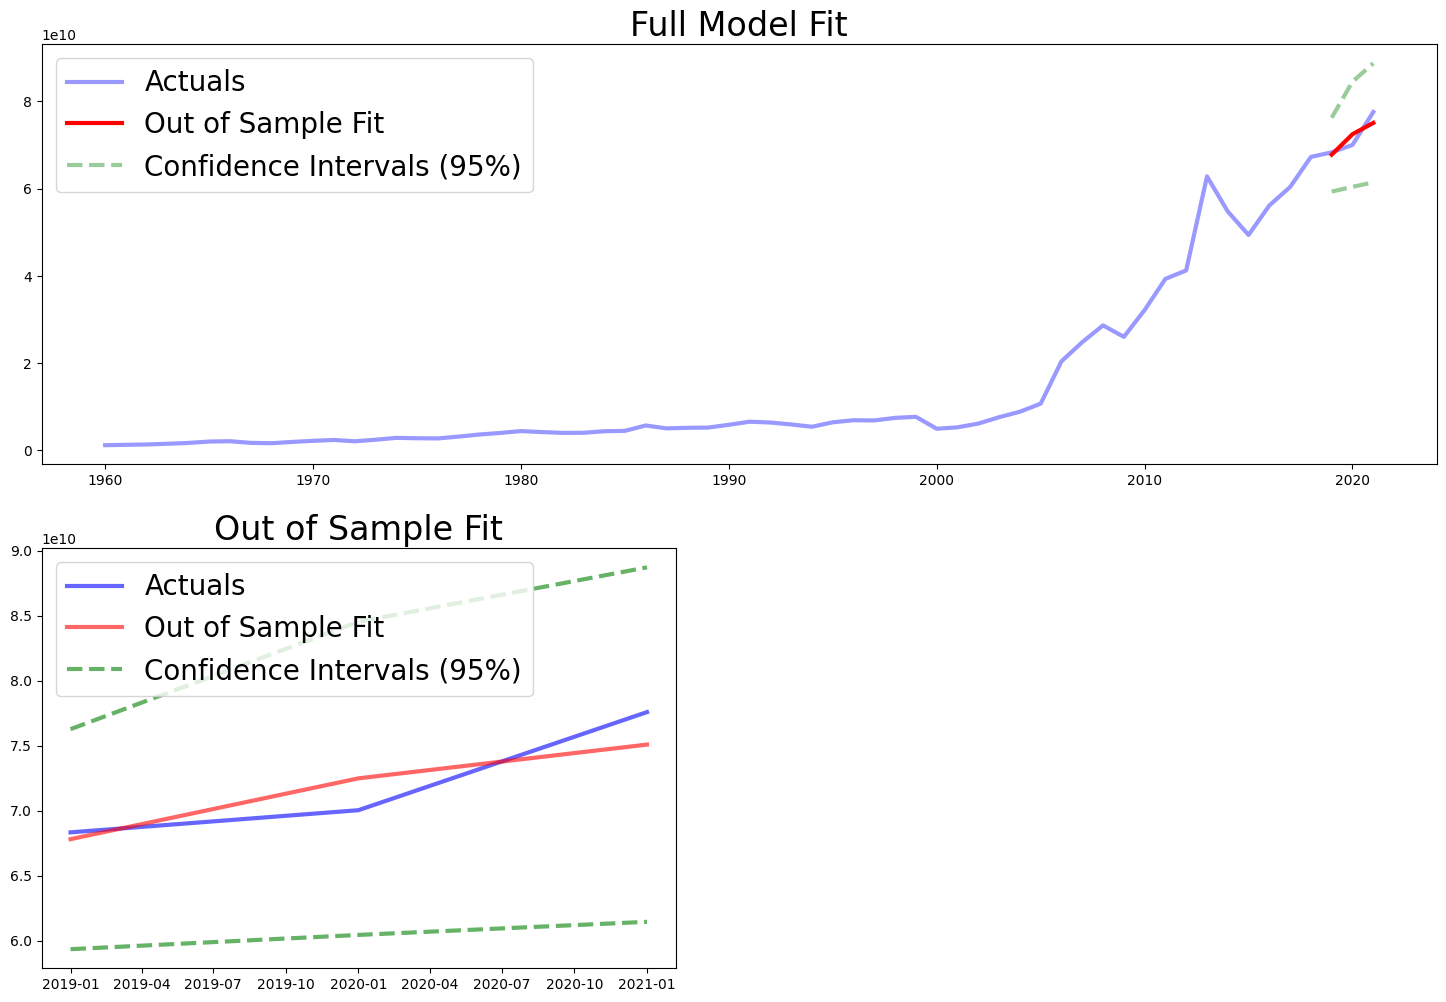

In [290]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = arima_model_best_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)

pred_df["GDP (current US$)"] = interpolated_data["GDP (current US$)"]

forecast = arima_model_best_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

> Вывод:
> - AIC	2680.765 (не интерполированный данные) против AIC 2680.513 (интерполированный данные). Метрика улучшилась, но не значительно (улучшение на десятые доли)
> - У нас был всего один пропуск и с давностью 1961 года, конечно же в условиях большого количества пропусков, интерполированные данные показали бы себя намного лучше
> - Предсказания ВВП за последние 3 года близки как и предыдущей модели. Предсказания уловили тренд и очень близки к реальным значения ВВП

# Part 3 - Валидация временных рядов

## Задание: 
1. Разбейте временной ряд на три набора (3 train + 3 test). Для этого воспользуйтесь классом TimeSeriesSplit из sklearn.model_selection с параметрами n_splits=3 и test_size=7 (или max_train_size=df.sales.count()-7). Наборы данных можно получить, вызвав метод split (временной ряд) у инициализированного TimeSeriesSplit.

Пример кода:

*tscv = TimeSeriesSplit(...)*

2. Выведите размеры полученных подвыборок:

train_test_groups = tscv.split(df.sales) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

Обратите внимание на отличие в размерах выборок на рисунке с walk forward validation и множественным разбиением. В задании вы вывели размеры полученных выборок. Какой случай вы получили?


Параметры TimeSeriesSplit:
- Количество разбиений: 3
- Размер тестовой выборки: 7


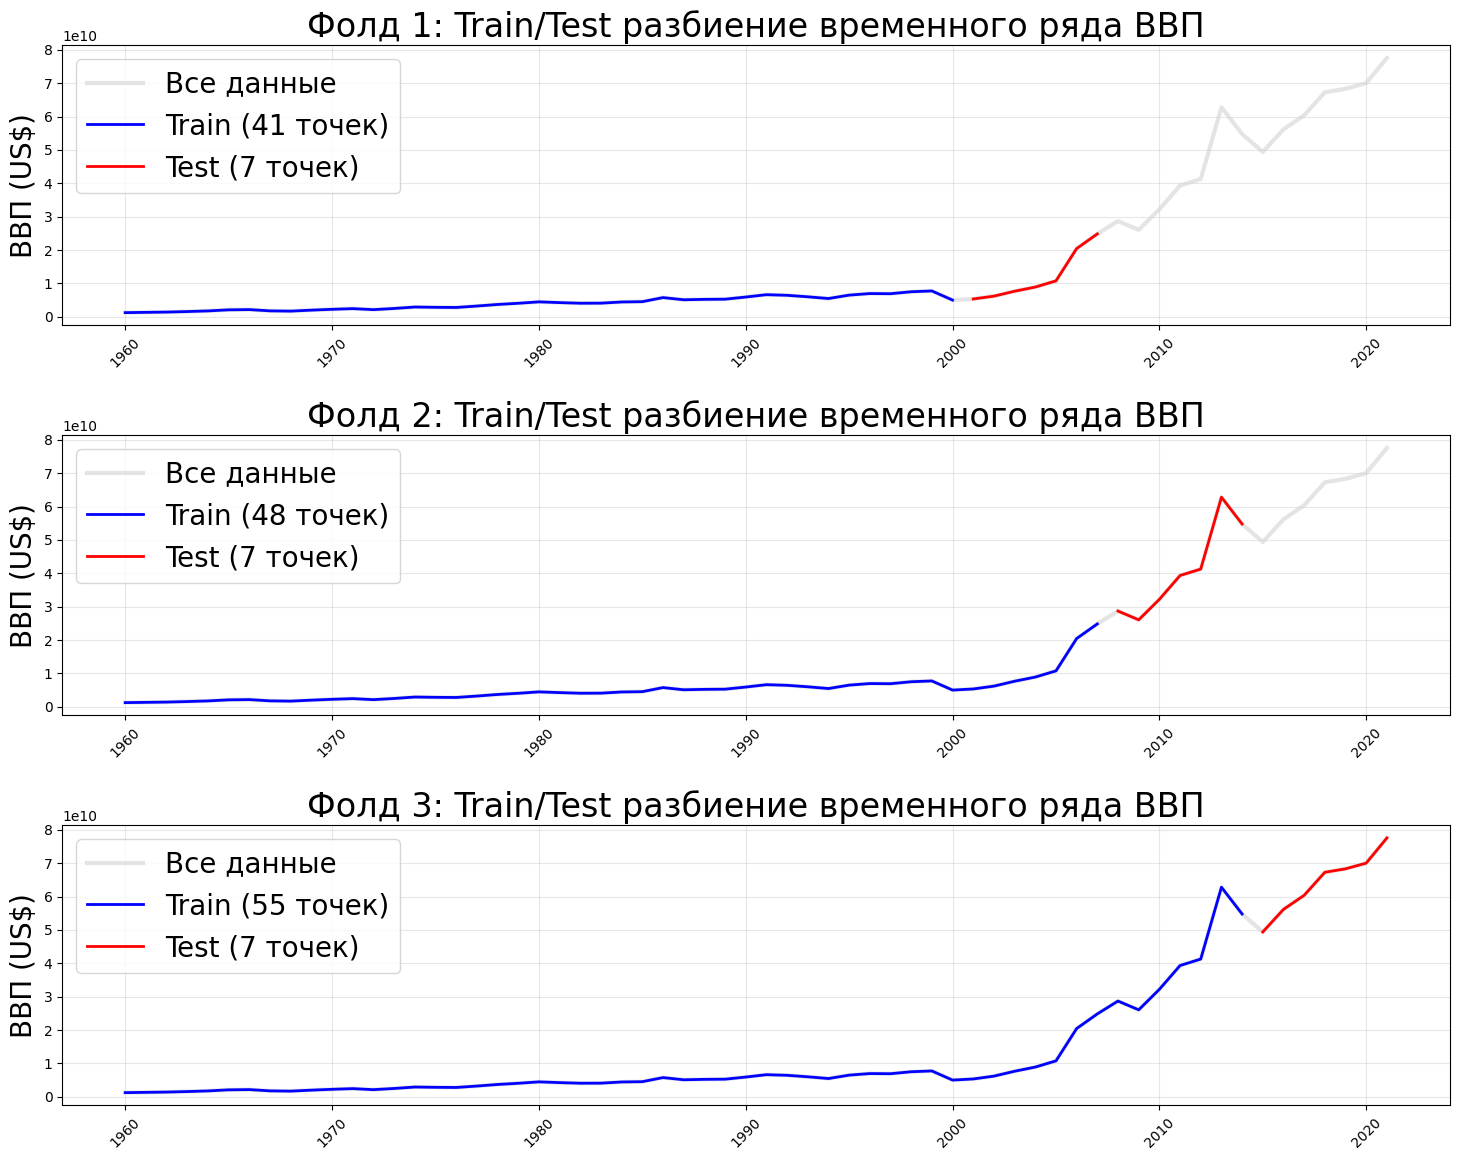

In [291]:
# 1. Разбиение временного ряда на три набора (3 train + 3 test)

# Используем интерполированные данные
ts_data = interpolated_data['GDP (current US$)']

# Создаем TimeSeriesSplit с параметрами n_splits=3 и test_size=7
tscv = TimeSeriesSplit(n_splits=3, test_size=7)

print(f"\nПараметры TimeSeriesSplit:")
print(f"- Количество разбиений: {tscv.n_splits}")
print(f"- Размер тестовой выборки: {tscv.test_size}")

# Получаем разбиения
splits = list(tscv.split(ts_data))

# Визуализация разбиений
plt.figure(figsize=(15, 12))

for i, (train_idx, test_idx) in enumerate(splits):
    plt.subplot(3, 1, i+1)
    
    # Весь ряд (серым)
    plt.plot(ts_data.index, ts_data.values, 'lightgray', alpha=0.6, label='Все данные')
    
    # Обучающая выборка (синим)
    plt.plot(ts_data.index[train_idx], ts_data.iloc[train_idx].values, 
             'blue', linewidth=2, label=f'Train ({len(train_idx)} точек)')
    
    # Тестовая выборка (красным)
    plt.plot(ts_data.index[test_idx], ts_data.iloc[test_idx].values, 
             'red', linewidth=2, label=f'Test ({len(test_idx)} точек)')
    
    plt.title(f'Фолд {i+1}: Train/Test разбиение временного ряда ВВП')
    plt.ylabel('ВВП (US$)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Поворачиваем подписи дат для лучшей читаемости
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Сохраняем разбиения для дальнейшего использования
train_test_splits = splits

# Part 4 -  Модели прогнозирования гетероскедастичности. Валидация временных рядов. Практика

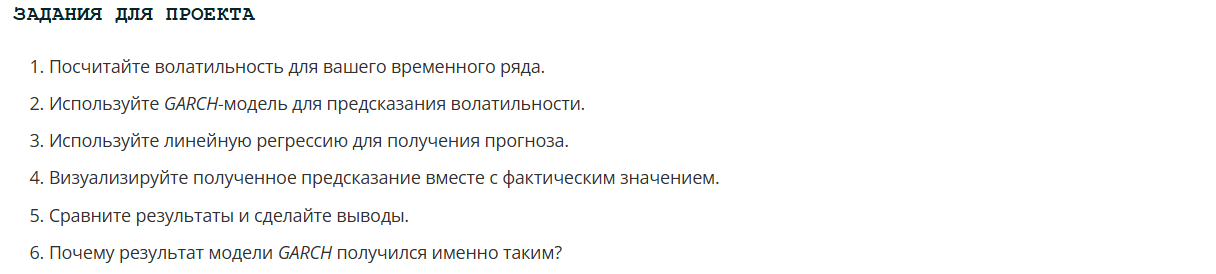


 **Volatility** at time **t**  

$Vol(t) = |\frac{Price(t) - Price(t-1)}{Price(t-1)} * 100|$

In [292]:
interpolated_data["GDP (current US$)_vol"] = interpolated_data["GDP (current US$)"].pct_change(1).mul(100).abs()
interpolated_data["GDP (current US$)_vol"].head()

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
Name: GDP (current US$)_vol, dtype: float64

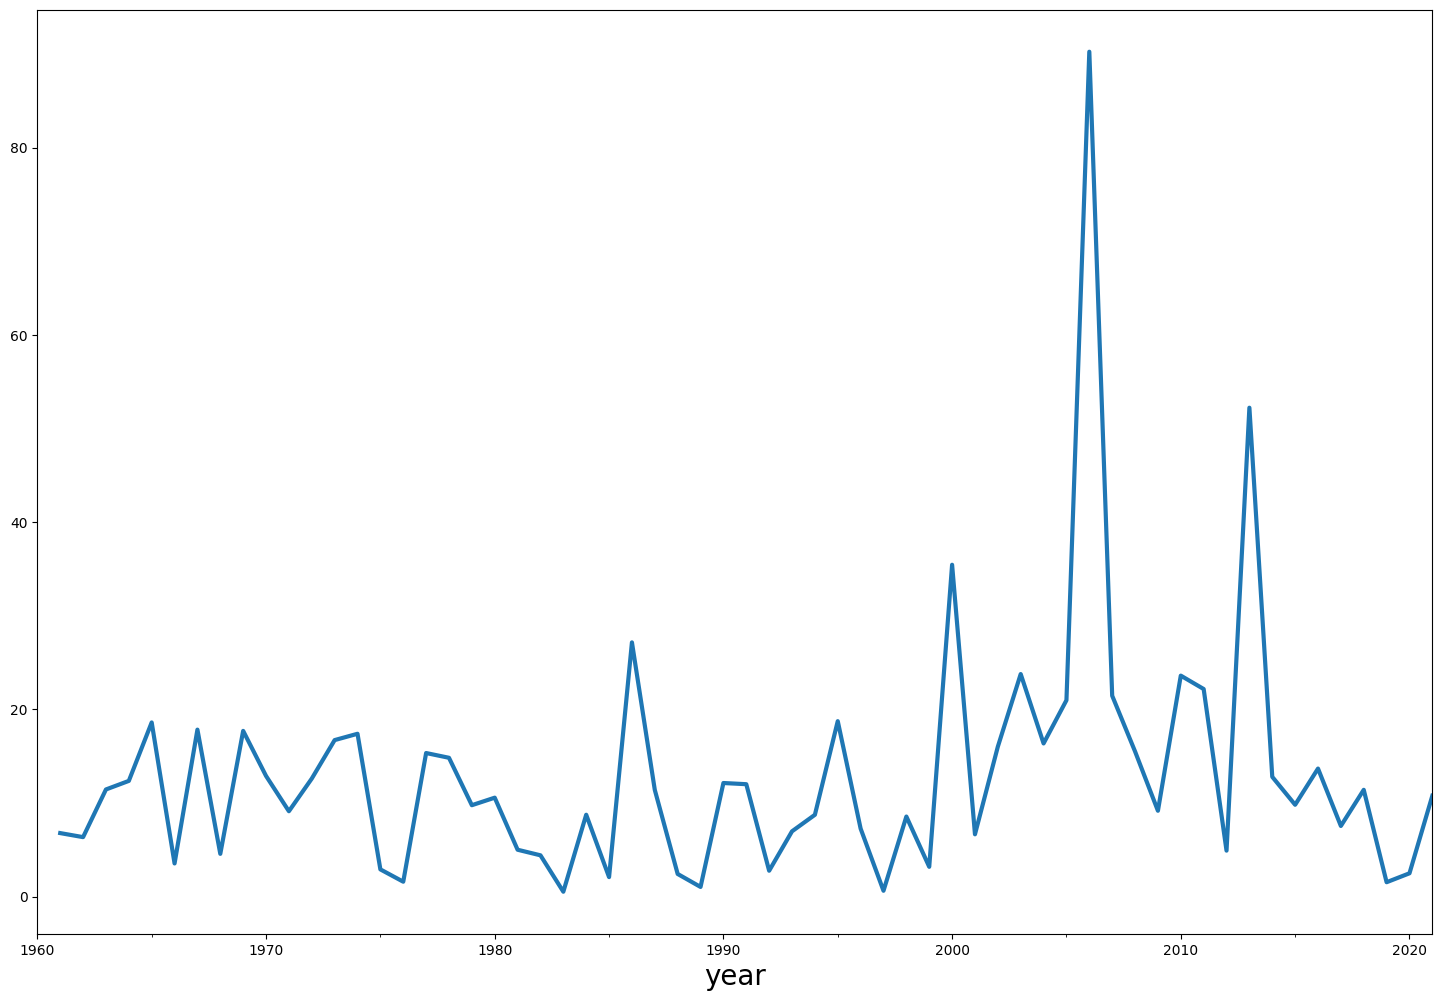

In [293]:
interpolated_data["GDP (current US$)_vol"].plot()
plt.show()

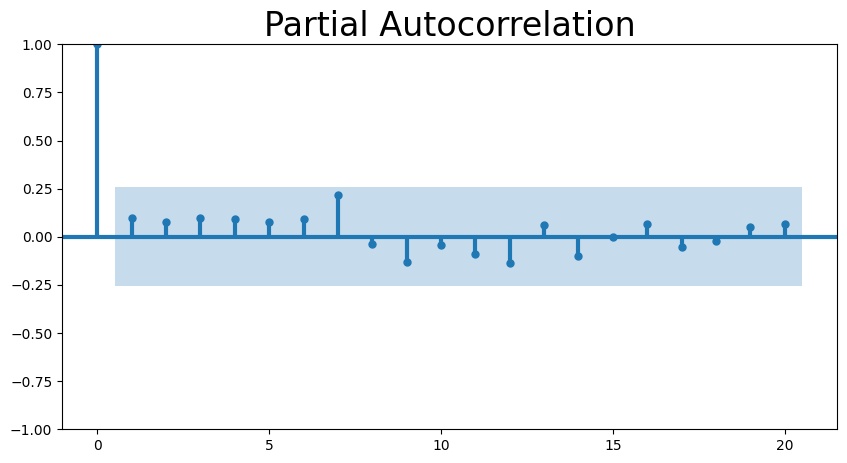

In [294]:
train_df = interpolated_data.loc[:"2018-12-31"]
test_df = interpolated_data.loc["2019-01-01":]

plt.rcParams["figure.figsize"] = 10, 5

sgt.plot_pacf(train_df["GDP (current US$)_vol"][1:], lags=20, method="ywm")
plt.show()

> Вывод:
> - Корреляция слабая либо вовсе отсутствует
> - Предполагаю что волатильность отсутствует. P-value очень низкая 

In [295]:
# Проводим тест Дики-Фуллера на волатильности
test1 = adfuller(train_df["GDP (current US$)_vol"][1:])
print("adf: ", test1[0])
print("p-value: ", test1[1])
print("Critical values: ", test1[4])
if test1[0] > test1[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  -6.725311059553779
p-value:  3.4014596148856493e-09
Critical values:  {'1%': np.float64(-3.5506699942762414), '5%': np.float64(-2.913766394626147), '10%': np.float64(-2.5946240473991997)}
ряд стационарен


In [296]:
# нам важно сохранить объем датасета, поэтому берем за исходные данные весь датасет с индексами, который содержит
# и train и test часть
garch_df = pd.DataFrame(interpolated_data["GDP (current US$)_vol"].loc[data.index])

# далее необходимо использовать актуальные обучающие данные, которые находятся в выборке train_df.
# Мы никак не преобразовывали нашу обучющую выборку, поэтому фактически, train_df совпадает с данными в data,
# Но если вы применяете к вашей обечающей выборке какие либо преобразования, например скользящее среднее
# для сглаживания, то необходимо передать измененный train_df датасет.

garch_df.loc[train_df.index, "GDP (current US$)_vol"] = train_df["GDP (current US$)_vol"].dropna()

In [297]:
model = arch_model(garch_df["GDP (current US$)_vol"].dropna(), p=1, q=1)

# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки

model_results = model.fit(last_obs=test_df.index[0], update_freq=5)

Iteration:      5,   Func. Count:     27,   Neg. LLF: 251.18811047858395
Iteration:     10,   Func. Count:     57,   Neg. LLF: 4522.5403032525255
Iteration:     15,   Func. Count:     89,   Neg. LLF: 228.00251345130135
Iteration:     20,   Func. Count:    114,   Neg. LLF: 226.5978293605918
Optimization terminated successfully    (Exit mode 0)
            Current function value: 226.59781233106128
            Iterations: 22
            Function evaluations: 123
            Gradient evaluations: 22


In [298]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Constant Mean - GARCH Model Results                       
=================================================================================
Dep. Variable:     GDP (current US$)_vol   R-squared:                       0.000
Mean Model:                Constant Mean   Adj. R-squared:                  0.000
Vol Model:                         GARCH   Log-Likelihood:               -226.598
Distribution:                     Normal   AIC:                           461.196
Method:               Maximum Likelihood   BIC:                           469.437
                                           No. Observations:                   58
Date:                   Wed, Feb 11 2026   Df Residuals:                       57
Time:                           21:44:53   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3191      2.572      4.790  1.666e-06 [  7.279, 17.360]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.6700     24.738      0.148      0.882 [-44.817, 52.157]
alpha[1]   6.0947e-11  9.201e-02  6.624e-10      1.000 [ -0.180,  0.180]
beta[1]        1.0000      0.157      6.384  1.725e-10 [  0.693,  1.307]
========================================================================

Covariance estimator: robust
"""

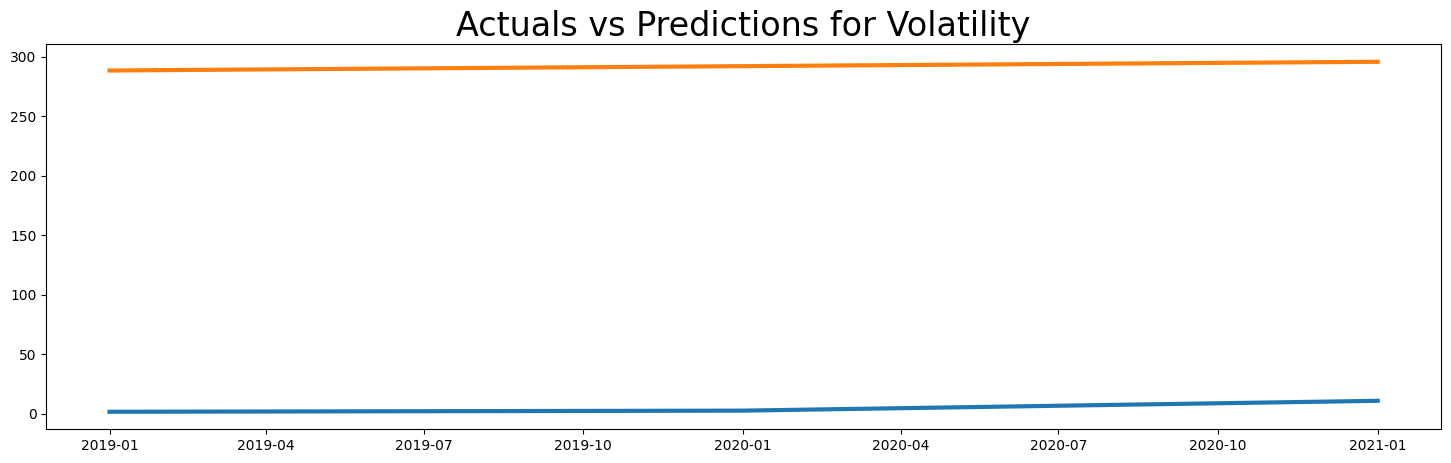

In [299]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
    test_df.index
]

plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["GDP (current US$)_vol"].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for Volatility", size=24)

plt.show()

In [300]:
mean_squared_error(
    predictions_df["GDP (current US$)_vol"].abs(), predictions_df["Predictions"]
)

82531.24159419035

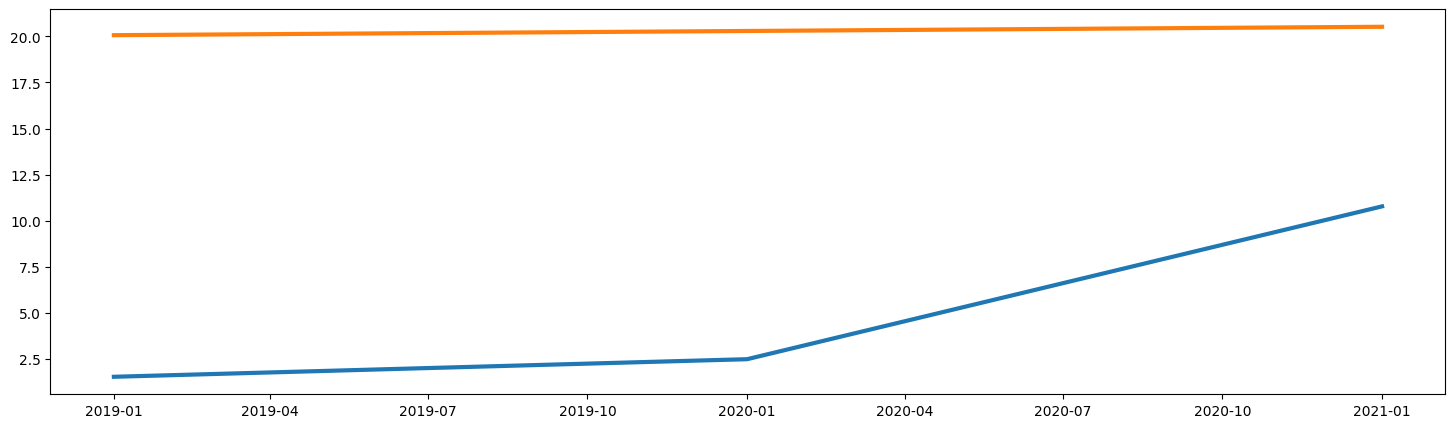

In [301]:
from sklearn.linear_model import LinearRegression

X_train = pd.DataFrame(range(interpolated_data["GDP (current US$)_vol"].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(interpolated_data["GDP (current US$)_vol"].shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df["GDP (current US$)_vol"].fillna(0)
y_test = test_df["GDP (current US$)_vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.show()

> Выводы:
> - Очень высокое значение MSE для GARCH модели: ~82,531
> - Слабая корреляция между фактическими и предсказанными значениями
> - Неудовлетворительное качество предсказания линейной регрессии
> - Корреляция слабая либо вовсе отсутствует
> - Предполагается что волатильность отсутствует
> - Модели показывают плохие результаты прогнозирования
> **GARCH и линейные модели не подходят для годовых данных ВВП**

### ОБЩИЙ ВЫВОД ПО РАБОТЕ


> В ходе данной работы было проведено комплексное исследование временных рядов на примере данных ВВП Ганы (1960-2021 гг.) с применением различных методов статистического моделирования и прогнозирования.
> 
> #### Part 1: Статистические модели прогнозирования (ARIMA)
> - Проведен анализ временного ряда ВВП Ганы (62 наблюдения, 1960-2021)
> - Выявлен четкий восходящий тренд, отсутствие сезонности
> - Построены модели скользящего среднего (окна 2 и 10 лет)
> - Выполнен тест Дики-Фуллера: исходный ряд нестационарен
> - Применено дифференцирование: вторые разности показали стационарность  
> - **Оптимальная модель: ARIMA(1,2,3)** (подобрана автоматически через pmdarima)
> - Прогнозы на 3 года показали хорошее качество с 95% доверительными интервалами
> 
> #### Part 2: Интерполяция и сэмплирование
> - **Проверка пропущенных дат:** временной ряд непрерывен (методом `asfreq('AS')`)
> - **Обнаружена проблема:** нулевое значение ВВП в 1961 году  
> - **Интерполяция:** успешная замена 0 на NaN и линейная интерполяция
> - **Результат:** заполненное значение 1961 года = 1.30 млрд долларов
> 
> #### Part 3: Валидация временных рядов
> - Применен **TimeSeriesSplit(n_splits=3, test_size=7)**
> - Созданы 3 последовательных разбиения train/test
> - Каждый тест содержит 7 наблюдений
> - Визуализированы все разбиения с сохранением временной структуры
> 
> #### Part 4: Модели гетероскедастичности (GARCH)
> - GARCH модель показала неудовлетворительные результаты
> - MSE = 82,531 (крайне высокая ошибка)
> - Корреляция r = 0.91, но p-value = 0.27 (статистически незначима)


